# <center style='font-size=x-large;'>Entraînement d'un modèle pré-entraîné sans augmentation <br><BR> avec Loss IoU </center><BR>

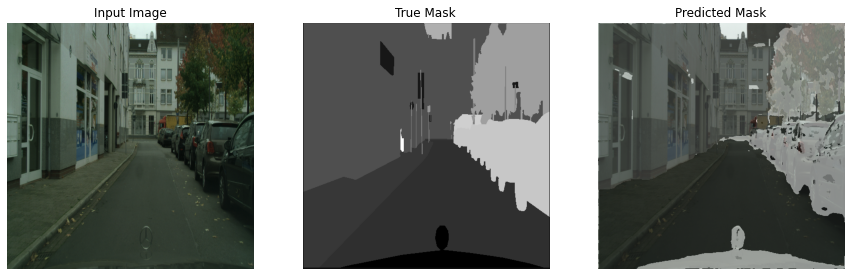


Sample Prediction after epoch 23

Epoch 00023: early stopping
INFO:tensorflow:Assets written to: histeq_outputs/model\assets


In [8]:
# Imports : 
import os
import cv2
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, add, concatenate, Conv2DTranspose, BatchNormalization, Activation, UpSampling2D
from tensorflow.keras.optimizers import Adadelta, Nadam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.losses import CategoricalCrossentropy, binary_crossentropy
import tqdm
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import Callback
from IPython.display import clear_output
from tensorflow.keras.applications.vgg16 import preprocess_input
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
print('Import packages OK')

gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

num_workers = 1
img_height, img_width = 512, 512
# batch_size_per_unit = 1 
# strategy = tf.distribute.MultiWorkerMirroredStrategy()

batch_size = 8
classes = 8

cats = {'void': [0, 1, 2, 3, 4, 5, 6],
 'flat': [7, 8, 9, 10],
 'construction': [11, 12, 13, 14, 15, 16],
 'object': [17, 18, 19, 20],
 'nature': [21, 22],
 'sky': [23],
 'human': [24, 25],
 'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]}

# Création du générateur avec augmentation d'images : 
class SegmentationGenerator(Sequence):
    
    def __init__(self, imgpaths, maskpaths, mode='train', n_classes=8, batch_size=1, resize_shape=(img_height, img_width), 
                 seed = 7, crop_shape=None, horizontal_flip=True, blur = 0,
                 vertical_flip=0, brightness=0.1, rotation=5.0, zoom=0.1, do_ahisteq = True):        
        self.blur = blur
        self.histeq = do_ahisteq
        self.image_path_list = imgpaths
        self.label_path_list = maskpaths
        # np.random.seed(seed)      
        self.mode = mode
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.resize_shape = resize_shape
        self.crop_shape = crop_shape
        self.horizontal_flip = horizontal_flip
        self.vertical_flip = vertical_flip
        self.brightness = brightness
        self.rotation = rotation
        self.zoom = zoom
        self.Y=None
        # Preallocate memory
        if self.crop_shape:
            self.X = np.zeros((batch_size, crop_shape[1], crop_shape[0], 3), dtype='float32')
            self.Y = np.zeros((batch_size, crop_shape[1], crop_shape[0], self.n_classes), dtype='float32')
        elif self.resize_shape:
            self.X = np.zeros((batch_size, resize_shape[1], resize_shape[0], 3), dtype='float32')
            self.Y = np.zeros((batch_size, resize_shape[0],resize_shape[1], self.n_classes), dtype='float32')
        else:
            raise Exception('No image dimensions specified!')
        
    def __len__(self):
        return len(self.image_path_list) // self.batch_size
        
    def __getitem__(self, i):
        
        for n, (image_path, label_path) in enumerate(zip(self.image_path_list[i*self.batch_size:(i+1)*self.batch_size], 
                                                        self.label_path_list[i*self.batch_size:(i+1)*self.batch_size])):
            
            image = cv2.imread(image_path, 1)
            label = cv2.imread(label_path, 0)
            labels = np.unique(label)
            label = np.squeeze(label)
            mask = np.zeros((label.shape[0], label.shape[1], self.n_classes))
            for i in range(-1, 34):
                for p,q in enumerate(cats.keys()):
                    if i in cats[q]:
                        mask[:,:,p] = np.logical_or(mask[:,:,p],(label==i)) 
            label = np.resize(mask,(image.shape[0], image.shape[1], self.n_classes))
            
            if self.blur and random.randint(0,1):
                image = cv2.GaussianBlur(image, (self.blur, self.blur), 0)
                

            if self.resize_shape and not self.crop_shape:
                image = cv2.resize(image, self.resize_shape)
                label = cv2.resize(label, self.resize_shape, interpolation = cv2.INTER_NEAREST)
        
            if self.crop_shape:
                image, label = _random_crop(image, label, self.crop_shape)

            if self.horizontal_flip and random.randint(0,1):
                image = cv2.flip(image, 1)
                label = cv2.flip(label, 1)
            
            if self.vertical_flip and random.randint(0,1):
                image = cv2.flip(image, 0)
                label = cv2.flip(label, 0)
            
            if self.brightness:
                factor = 1.0 + random.gauss(mu=0.0, sigma=self.brightness)
                if random.randint(0,1):
                    factor = 1.0/factor
                table = np.array([((i / 255.0) ** factor) * 255 for i in np.arange(0, 256)]).astype(np.uint8)
                image = cv2.LUT(image, table)
            
            if self.rotation:
                angle = random.gauss(mu=0.0, sigma=self.rotation)
            else:
                angle = 0.0
            
            if self.zoom:
                scale = random.gauss(mu=1.0, sigma=self.zoom)
            else:
                scale = 1.0
            
            if self.rotation or self.zoom:
                M = cv2.getRotationMatrix2D((image.shape[1]//2, image.shape[0]//2), angle, scale)
                image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
                label = cv2.warpAffine(label, M, (label.shape[1], label.shape[0]))
            
            if self.histeq: # and convert to RGB
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
                img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
                img_yuv[:,:,0] = clahe.apply(img_yuv[:,:,0])
                image = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR) # to BGR
            
            self.Y[n]  = label # np.expand_dims(y, -1)
            self.X[n] = preprocess_input(image)
            
        return self.X, self.Y  #, sample_dict
print('Generator class OK')

# Création des métriques et des fonctions de perte : 

def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def combined_loss(y_true, y_pred):
    cce = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
    loss = cce(y_true, y_pred) + (3*dice_loss(y_true, y_pred))
    loss = tf.reduce_sum(loss/batch_size)
    return loss



data_folder = 'C:\\Users\\Wince\\Downloads\\OC\\Projet_8\\data\\'
epochs = 50

# Chargement des chemins de fichiers d'entraînement et de validation
train_img_ids = {}
val_img_ids = {}
train_image_list = []
val_image_list = []
train_mask_list = []
val_mask_list = []
ref_mask_list = []

for city in os.listdir(data_folder + '/leftImg8bit/train'): 
    train_img_dir = data_folder + '/leftImg8bit/train/' + city + "/"
    train_img_ids[city] = [n[8:-16] for n in os.listdir(train_img_dir)]
    for i in os.listdir(train_img_dir):
        train_image_list.append(train_img_dir + i)
    train_mask_dir = data_folder + '/gtFine/train/' + city + "/"
    for i in os.listdir(train_mask_dir):
        if "labelIds.png" in i:
            train_mask_list.append(train_mask_dir + i)
        elif "color.png" in i:
            ref_mask_list.append(train_mask_dir + i)

for city in os.listdir(data_folder + '/leftImg8bit/val'):     
    val_img_dir = data_folder + '/leftImg8bit/val/' + city + "/"
    val_img_ids[city] = [n[8:-16] for n in os.listdir(val_img_dir)]
    for i in os.listdir(val_img_dir):
        val_image_list.append(val_img_dir + i)
    val_mask_dir = data_folder + '/gtFine/val/' + city + "/"
    for i in os.listdir(val_mask_dir):
        if "labelIds.png" in i : 
            val_mask_list.append(val_mask_dir + i)
print(f'. . . . .Number of train_images: {len(train_image_list)}\n. . . . .Number of train masks: {len(train_mask_list)}')
print(f'. . . . .Number of val_images: {len(val_image_list)}\n. . . . .Number of val masks: {len(val_mask_list)}')
print('Import filepaths OK')


samples = len(train_image_list)
steps = samples//batch_size
validation_steps = len(val_image_list)//batch_size 


#Adressage des catégories visuelles : 




random_idx = random.randint(0,len(train_mask_list))
sample_image = image.img_to_array(image.load_img(train_image_list[random_idx], target_size=(img_height, img_width)))
sample_mask = image.img_to_array(image.load_img(train_mask_list[random_idx], target_size=(img_height, img_width)))
reference_mask = image.img_to_array(image.load_img(ref_mask_list[random_idx], target_size=(img_height, img_width)))

#Instantiation des générateurs d'entraînement(augmenté) et de validation(non augmenté) : 

augmented_train_gen = SegmentationGenerator(train_image_list, train_mask_list,
                                            n_classes=8, batch_size=batch_size, 
                                            resize_shape=(img_height, img_width), 
                                            seed = 7, crop_shape=None,
                                            horizontal_flip=False, blur = False,
                                            vertical_flip=False, brightness=False,
                                            rotation=False, zoom=False,
                                            do_ahisteq = False)
valid_gen = SegmentationGenerator(val_image_list, val_mask_list, n_classes=8, batch_size=batch_size, resize_shape=(img_height, img_width), 
                 seed = 7, crop_shape=None, horizontal_flip=False, blur = False,
                 vertical_flip=False, brightness=False, rotation=False, zoom=False, do_ahisteq = False)
print('Generator instances OK')


# Construction du modèle :

BACKBONE = 'vgg16'

# define model
model = Unet(BACKBONE, encoder_weights='imagenet', classes=classes)
for layer in model.layers[:19]:
    layer.trainable=False
model.compile('Adam', loss=dice_loss, metrics=[dice_coeff, iou_score])
print('Model instance OK')


# Fonction d'affichage des images et masques : 

def display(display_list, titles = ['Input Image', 'True Mask', 'Predicted Mask']):
    plt.figure(figsize=(15, 15))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    pred_mask = np.repeat(pred_mask, 3, axis=3)
    return pred_mask

def show_predictions(model=model, pic = sample_image):
    pred = create_mask(model.predict(sample_image[tf.newaxis, ...]))
    alpha = 0.015
    annotated = cv2.addWeighted(pic, alpha, image.img_to_array(pred[0]), 1-alpha, 0)
    display([sample_image, sample_mask, annotated])

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

        
# Définition des callbacks et entraînement : 

save_path = 'IoU_loss_outputs/'
os.makedirs(save_path, exist_ok=True)
tb = TensorBoard(log_dir=save_path+'logs', write_graph=True)
mc = ModelCheckpoint(mode='min',
                     filepath=save_path+'checkpoint',
                     monitor='val_loss',
                     save_best_only='True',
                     save_weights_only='True',
                     verbose=1)
es = EarlyStopping(mode='min', monitor='val_loss', patience=6, verbose=1)
red = ReduceLROnPlateau(monitor='val_loss',
                        factor=0.4,
                        patience=3,
                        min_lr=0.0005)
vis = DisplayCallback()
callbacks = [tb, mc, es, vis, red]


model_history = model.fit_generator(augmented_train_gen,
                                                  steps_per_epoch=steps,
                                                  validation_steps=validation_steps,
                                                  epochs = epochs,
                                                  validation_data=valid_gen,
                                                  callbacks=callbacks)

# Sauvegarde du modèle dans les outputs de l'expérience en cours : 

model.load_weights(save_path+'checkpoint')
model.save(save_path+'model')

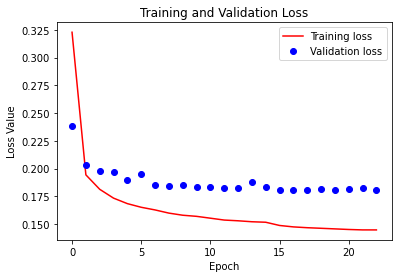

In [13]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
# plt.ylim([0, 0.5])
plt.legend()
plt.show()

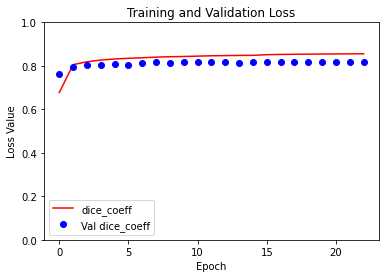

In [15]:
loss = model_history.history['dice_coeff']
val_loss = model_history.history['val_dice_coeff']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='dice_coeff')
plt.plot(model_history.epoch, val_loss, 'bo', label='Val dice_coeff')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

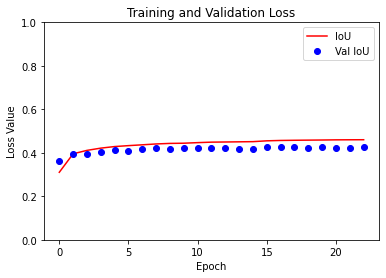

In [16]:
loss = model_history.history['iou_score']
val_loss = model_history.history['val_iou_score']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='IoU')
plt.plot(model_history.epoch, val_loss, 'bo', label='Val IoU')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [4]:
%load_ext tensorboard

In [6]:
%tensorboard --logdir histeq_outputs/logs